In [1]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

c:\users\georg\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
import json
train_idx = loadmat('PR_data/cuhk03_new_protocol_config_labeled.mat')['train_idx'].flatten()
camId = loadmat('PR_data/cuhk03_new_protocol_config_labeled.mat')['camId'].flatten()
filelist = loadmat('PR_data/cuhk03_new_protocol_config_labeled.mat')['filelist'].flatten()
gallery_idx = loadmat('PR_data/cuhk03_new_protocol_config_labeled.mat')['gallery_idx'].flatten()
labels = loadmat('PR_data/cuhk03_new_protocol_config_labeled.mat')['labels'].flatten()
query_idx = loadmat('PR_data/cuhk03_new_protocol_config_labeled.mat')['query_idx'].flatten()
with open('PR_data/feature_data.json', 'r') as f:
    features = np.array(json.load(f))
train_idx -= 1
gallery_idx -= 1
query_idx -= 1
features = np.divide(features,np.amax(features))

In [3]:
train_features = features[train_idx.tolist()]
gallery_features = features[gallery_idx.tolist()]
query_features = features[query_idx.tolist()]

train_label = labels[train_idx.tolist()]
gallery_label = labels[gallery_idx.tolist()]
query_label = labels[query_idx.tolist()]

train_cam = camId[train_idx.tolist()]
gallery_cam = camId[gallery_idx.tolist()]
query_cam = camId[query_idx.tolist()]

labeled_train = np.asarray(list(zip(train_features, train_label, train_cam)))
labeled_gallery = np.asarray(list(zip(gallery_features, gallery_label, gallery_cam)))
labeled_query = np.asarray(list(zip(query_features, query_label, query_cam)))

### Formalise training data into input triples and output pairs

In [4]:
import random as rand
from more_itertools import locate

in_triples_train = np.empty((7368, 3), int)
out_pairs_train =  np.empty((7368, 2), int)
for i in range(labeled_train.shape[0]) :

    
    current_id = labeled_train[i][1]
    current_cam = labeled_train[i][2]
    #ensure there are three unique ID's randomly selected
    rand_id1 = rand.choice(train_label)
    rand_id2 = rand.choice(train_label)
    while not((rand_id1 != current_id) and (rand_id2 != current_id) and (rand_id1 != rand_id2)) :
        rand_id1 = rand.choice(train_label)
        rand_id2 = rand.choice(train_label)


    triple_set = list(locate(labeled_train, lambda x: 
                        (x[1] == current_id and x[2] != current_cam)  
                        or (x[1] == rand_id1)
                        or (x[1] == rand_id2)
                            ))

    triple_1 = rand.choice(triple_set)
    triple_2 = rand.choice(triple_set)
    while triple_1 == triple_2 : 
        triple_1 = rand.choice(triple_set)
        triple_2 = rand.choice(triple_set)

    in_triples_train[i] = [triple_1, i, triple_2]

    out_pairs_train[i] = [(current_id == labeled_train[triple_1][1]),(current_id == labeled_train[triple_2][1])]

### Formalise test data into input triple and output pairs

In [5]:
x_train = np.empty((7368, 3, 2048), float)
for i in range(in_triples_train.shape[0]):
    x_train[i] = train_features[in_triples_train[i]]
    

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)

y_train = out_pairs_train

### Set up Neural Network

In [44]:


input_shape = (3, 2048, 1)

model = Sequential()
model.add(Conv2D(32, kernel_size=(2, 2),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (2, 2), activation='relu'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

batch_size = 128
epochs = 20

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1)
# score = model.evaluate(x_test, y_test, verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

Epoch 1/20
7368/7368 [==============================] - ETA: 1:07 - loss: 0.2980 - acc: 0.375 - ETA: 37s - loss: 0.3006 - acc: 0.378 - ETA: 27s - loss: 0.2937 - acc: 0.53 - ETA: 22s - loss: 0.3044 - acc: 0.59 - ETA: 19s - loss: 0.2918 - acc: 0.51 - ETA: 17s - loss: 0.2810 - acc: 0.46 - ETA: 16s - loss: 0.2824 - acc: 0.42 - ETA: 14s - loss: 0.2816 - acc: 0.39 - ETA: 13s - loss: 0.2813 - acc: 0.43 - ETA: 13s - loss: 0.2809 - acc: 0.40 - ETA: 12s - loss: 0.2759 - acc: 0.42 - ETA: 11s - loss: 0.2762 - acc: 0.43 - ETA: 11s - loss: 0.2758 - acc: 0.42 - ETA: 10s - loss: 0.2739 - acc: 0.44 - ETA: 10s - loss: 0.2741 - acc: 0.46 - ETA: 9s - loss: 0.2743 - acc: 0.4604 - ETA: 9s - loss: 0.2707 - acc: 0.440 - ETA: 9s - loss: 0.2706 - acc: 0.450 - ETA: 8s - loss: 0.2682 - acc: 0.437 - ETA: 8s - loss: 0.2664 - acc: 0.460 - ETA: 8s - loss: 0.2691 - acc: 0.476 - ETA: 7s - loss: 0.2672 - acc: 0.462 - ETA: 7s - loss: 0.2698 - acc: 0.458 - ETA: 7s - loss: 0.2720 - acc: 0.474 - ETA: 7s - loss: 0.2733 - acc

7368/7368 [==============================] - ETA: 9s - loss: 0.0280 - acc: 0.835 - ETA: 9s - loss: 0.0348 - acc: 0.750 - ETA: 9s - loss: 0.0490 - acc: 0.687 - ETA: 9s - loss: 0.0545 - acc: 0.679 - ETA: 8s - loss: 0.0465 - acc: 0.678 - ETA: 8s - loss: 0.0468 - acc: 0.656 - ETA: 8s - loss: 0.0493 - acc: 0.646 - ETA: 8s - loss: 0.0495 - acc: 0.659 - ETA: 8s - loss: 0.0559 - acc: 0.648 - ETA: 8s - loss: 0.0554 - acc: 0.655 - ETA: 7s - loss: 0.0539 - acc: 0.632 - ETA: 7s - loss: 0.0534 - acc: 0.623 - ETA: 7s - loss: 0.0523 - acc: 0.622 - ETA: 7s - loss: 0.0536 - acc: 0.612 - ETA: 7s - loss: 0.0556 - acc: 0.619 - ETA: 6s - loss: 0.0550 - acc: 0.621 - ETA: 6s - loss: 0.0541 - acc: 0.622 - ETA: 6s - loss: 0.0532 - acc: 0.626 - ETA: 6s - loss: 0.0547 - acc: 0.621 - ETA: 6s - loss: 0.0548 - acc: 0.628 - ETA: 6s - loss: 0.0546 - acc: 0.619 - ETA: 5s - loss: 0.0544 - acc: 0.621 - ETA: 5s - loss: 0.0533 - acc: 0.616 - ETA: 5s - loss: 0.0541 - acc: 0.617 - ETA: 5s - loss: 0.0540 - acc: 0.614 - ETA: 

7368/7368 [==============================] - ETA: 8s - loss: 0.0244 - acc: 0.640 - ETA: 8s - loss: 0.0567 - acc: 0.652 - ETA: 8s - loss: 0.0455 - acc: 0.656 - ETA: 8s - loss: 0.0427 - acc: 0.658 - ETA: 8s - loss: 0.0483 - acc: 0.626 - ETA: 8s - loss: 0.0533 - acc: 0.645 - ETA: 8s - loss: 0.0531 - acc: 0.622 - ETA: 8s - loss: 0.0591 - acc: 0.630 - ETA: 7s - loss: 0.0554 - acc: 0.638 - ETA: 7s - loss: 0.0557 - acc: 0.642 - ETA: 7s - loss: 0.0518 - acc: 0.634 - ETA: 7s - loss: 0.0504 - acc: 0.640 - ETA: 7s - loss: 0.0500 - acc: 0.642 - ETA: 7s - loss: 0.0467 - acc: 0.647 - ETA: 7s - loss: 0.0492 - acc: 0.661 - ETA: 6s - loss: 0.0516 - acc: 0.647 - ETA: 6s - loss: 0.0508 - acc: 0.657 - ETA: 6s - loss: 0.0518 - acc: 0.658 - ETA: 6s - loss: 0.0511 - acc: 0.660 - ETA: 6s - loss: 0.0504 - acc: 0.661 - ETA: 6s - loss: 0.0518 - acc: 0.653 - ETA: 5s - loss: 0.0526 - acc: 0.657 - ETA: 5s - loss: 0.0518 - acc: 0.651 - ETA: 5s - loss: 0.0511 - acc: 0.647 - ETA: 5s - loss: 0.0492 - acc: 0.648 - ETA: 

7368/7368 [==============================] - ETA: 9s - loss: 0.0454 - acc: 0.742 - ETA: 9s - loss: 0.0449 - acc: 0.742 - ETA: 9s - loss: 0.0452 - acc: 0.713 - ETA: 9s - loss: 0.0537 - acc: 0.675 - ETA: 8s - loss: 0.0432 - acc: 0.675 - ETA: 8s - loss: 0.0416 - acc: 0.679 - ETA: 8s - loss: 0.0404 - acc: 0.685 - ETA: 8s - loss: 0.0415 - acc: 0.686 - ETA: 8s - loss: 0.0421 - acc: 0.675 - ETA: 7s - loss: 0.0437 - acc: 0.685 - ETA: 7s - loss: 0.0490 - acc: 0.682 - ETA: 7s - loss: 0.0479 - acc: 0.683 - ETA: 7s - loss: 0.0493 - acc: 0.680 - ETA: 7s - loss: 0.0491 - acc: 0.687 - ETA: 7s - loss: 0.0466 - acc: 0.682 - ETA: 6s - loss: 0.0466 - acc: 0.679 - ETA: 6s - loss: 0.0505 - acc: 0.676 - ETA: 6s - loss: 0.0520 - acc: 0.672 - ETA: 6s - loss: 0.0523 - acc: 0.673 - ETA: 6s - loss: 0.0530 - acc: 0.666 - ETA: 6s - loss: 0.0522 - acc: 0.662 - ETA: 5s - loss: 0.0509 - acc: 0.660 - ETA: 5s - loss: 0.0506 - acc: 0.656 - ETA: 5s - loss: 0.0504 - acc: 0.653 - ETA: 5s - loss: 0.0494 - acc: 0.652 - ETA: 

7368/7368 [==============================] - ETA: 6s - loss: 0.0568 - acc: 0.617 - ETA: 7s - loss: 0.0400 - acc: 0.668 - ETA: 6s - loss: 0.0423 - acc: 0.669 - ETA: 6s - loss: 0.0347 - acc: 0.693 - ETA: 6s - loss: 0.0350 - acc: 0.693 - ETA: 6s - loss: 0.0349 - acc: 0.683 - ETA: 6s - loss: 0.0399 - acc: 0.665 - ETA: 6s - loss: 0.0395 - acc: 0.678 - ETA: 6s - loss: 0.0450 - acc: 0.671 - ETA: 6s - loss: 0.0416 - acc: 0.678 - ETA: 6s - loss: 0.0429 - acc: 0.679 - ETA: 5s - loss: 0.0442 - acc: 0.674 - ETA: 5s - loss: 0.0418 - acc: 0.672 - ETA: 5s - loss: 0.0412 - acc: 0.666 - ETA: 5s - loss: 0.0400 - acc: 0.672 - ETA: 5s - loss: 0.0409 - acc: 0.675 - ETA: 5s - loss: 0.0444 - acc: 0.678 - ETA: 5s - loss: 0.0451 - acc: 0.671 - ETA: 5s - loss: 0.0433 - acc: 0.670 - ETA: 4s - loss: 0.0434 - acc: 0.671 - ETA: 4s - loss: 0.0429 - acc: 0.670 - ETA: 4s - loss: 0.0432 - acc: 0.671 - ETA: 4s - loss: 0.0447 - acc: 0.666 - ETA: 4s - loss: 0.0438 - acc: 0.666 - ETA: 4s - loss: 0.0438 - acc: 0.663 - ETA: 

7368/7368 [==============================] - ETA: 7s - loss: 0.0222 - acc: 0.679 - ETA: 7s - loss: 0.0390 - acc: 0.652 - ETA: 7s - loss: 0.0299 - acc: 0.690 - ETA: 7s - loss: 0.0389 - acc: 0.687 - ETA: 7s - loss: 0.0444 - acc: 0.685 - ETA: 7s - loss: 0.0448 - acc: 0.691 - ETA: 7s - loss: 0.0448 - acc: 0.670 - ETA: 6s - loss: 0.0477 - acc: 0.669 - ETA: 6s - loss: 0.0487 - acc: 0.684 - ETA: 6s - loss: 0.0450 - acc: 0.693 - ETA: 6s - loss: 0.0441 - acc: 0.698 - ETA: 6s - loss: 0.0423 - acc: 0.703 - ETA: 6s - loss: 0.0442 - acc: 0.691 - ETA: 6s - loss: 0.0459 - acc: 0.688 - ETA: 5s - loss: 0.0465 - acc: 0.685 - ETA: 5s - loss: 0.0477 - acc: 0.683 - ETA: 5s - loss: 0.0495 - acc: 0.688 - ETA: 5s - loss: 0.0474 - acc: 0.687 - ETA: 5s - loss: 0.0496 - acc: 0.691 - ETA: 5s - loss: 0.0511 - acc: 0.690 - ETA: 5s - loss: 0.0498 - acc: 0.696 - ETA: 4s - loss: 0.0525 - acc: 0.693 - ETA: 4s - loss: 0.0535 - acc: 0.697 - ETA: 4s - loss: 0.0523 - acc: 0.697 - ETA: 4s - loss: 0.0542 - acc: 0.694 - ETA: 

7368/7368 [==============================] - ETA: 9s - loss: 0.0655 - acc: 0.656 - ETA: 9s - loss: 0.0603 - acc: 0.628 - ETA: 9s - loss: 0.0550 - acc: 0.630 - ETA: 9s - loss: 0.0442 - acc: 0.666 - ETA: 9s - loss: 0.0528 - acc: 0.668 - ETA: 8s - loss: 0.0552 - acc: 0.694 - ETA: 8s - loss: 0.0521 - acc: 0.694 - ETA: 7s - loss: 0.0510 - acc: 0.687 - ETA: 7s - loss: 0.0515 - acc: 0.690 - ETA: 7s - loss: 0.0519 - acc: 0.682 - ETA: 7s - loss: 0.0512 - acc: 0.690 - ETA: 7s - loss: 0.0506 - acc: 0.687 - ETA: 6s - loss: 0.0476 - acc: 0.690 - ETA: 6s - loss: 0.0489 - acc: 0.693 - ETA: 6s - loss: 0.0486 - acc: 0.689 - ETA: 6s - loss: 0.0484 - acc: 0.685 - ETA: 6s - loss: 0.0526 - acc: 0.690 - ETA: 5s - loss: 0.0510 - acc: 0.685 - ETA: 5s - loss: 0.0512 - acc: 0.680 - ETA: 5s - loss: 0.0492 - acc: 0.680 - ETA: 5s - loss: 0.0500 - acc: 0.680 - ETA: 5s - loss: 0.0498 - acc: 0.682 - ETA: 5s - loss: 0.0500 - acc: 0.689 - ETA: 4s - loss: 0.0507 - acc: 0.689 - ETA: 4s - loss: 0.0495 - acc: 0.696 - ETA: 

In [45]:
# model.save('model20181211_7029.h5')

``` python
    predict([gallery[i], [query], [gallery[!i])                           
```
- ensure query[!i] does not use the same camera as test_data
- for each i generate highest probability test_data matches to it with all other queries !i (set to zero for invalid !i)
- sort the list of probabilities indexed for query[i]
- choose top *r* depending on rank
- gereate score 1 or 0 dependin on if the correct match is found within that rank
- repeat for all Test_data


Alternate prediction loop choosing a single K with a different label to I

In [7]:
from tqdm import tqdm_notebook as tqdm
predictions = np.zeros((1400, 5328, 3))

# for i in tqdm(range(labeled_gallery.shape[0])) :
for i in tqdm(range(predictions.shape[0])) :
    j_pred = np.zeros((5328, 3))
    
    k = rand.randrange(gallery_label.shape[0])

    for j in range(labeled_gallery.shape[0]):
        k_pred = 0
        
        
        if k == j: #check for same data point or same cam
            continue
        x_pred = np.empty((1, 3, 2048), float)
        x_pred[0][0] = gallery_features[j]
        x_pred[0][1] = query_features[i]
        x_pred[0][2] = gallery_features[k]
        x_pred = x_pred.reshape(1, 3, 2048, 1)
        k_pred = model.predict(x_pred)[0][0]
        
#         print(k_pred , labeled_query[j][1])
         
        
        j_pred[j] = [k_pred, labeled_gallery[j][1], labeled_gallery[j][2]] #store best prediction and its ID
        
    inds = np.argsort(j_pred.T[0])
    j_pred = np.asarray(list(zip(j_pred.T[0][inds], j_pred.T[1][inds], j_pred.T[2][inds])))
#     print(j_pred)
    predictions[i] = j_pred #sort list by descending probability


#predictions should now be an sorted array of best predictions of each 
#gallery image in descenting order in a list with the corresponding predicted ID

##### Get the rank accuracies of the resulting predictions

In [29]:
ranks = range(1,101) #set ranks in a list to check
rank_scores = [0]*len(ranks)
# for i in range(predictions.shape[0]) :
for i in range(predictions.shape[0]) :
    cam_match = 0
    for j in range(predictions.shape[1]):
        if int(predictions[i][5327-j][1]) == labeled_query[i][1] and int(predictions[i][5327-j][2]) != labeled_query[i][2]:
            for k in range(len(ranks)):
                if j - cam_match <= ranks[k]-1:
                    rank_scores[k] += 1
            break
        elif int(predictions[i][5327-j][1]) == labeled_query[i][1] and int(predictions[i][5327-j][2]) == labeled_query[i][2]:
            cam_match += 1

for i in range(len(rank_scores)) :
    rank_scores[i] = rank_scores[i]/predictions.shape[0]
    print('Rank: ', ranks[i], ' Accuracy: ', rank_scores[i])

Rank:  1  Accuracy:  0.4642857142857143
Rank:  2  Accuracy:  0.5414285714285715
Rank:  3  Accuracy:  0.5957142857142858
Rank:  4  Accuracy:  0.6414285714285715
Rank:  5  Accuracy:  0.6742857142857143
Rank:  6  Accuracy:  0.6957142857142857
Rank:  7  Accuracy:  0.7085714285714285
Rank:  8  Accuracy:  0.7285714285714285
Rank:  9  Accuracy:  0.7414285714285714
Rank:  10  Accuracy:  0.7478571428571429
Rank:  11  Accuracy:  0.7585714285714286
Rank:  12  Accuracy:  0.7714285714285715
Rank:  13  Accuracy:  0.785
Rank:  14  Accuracy:  0.7935714285714286
Rank:  15  Accuracy:  0.8007142857142857
Rank:  16  Accuracy:  0.8071428571428572
Rank:  17  Accuracy:  0.81
Rank:  18  Accuracy:  0.8128571428571428
Rank:  19  Accuracy:  0.8214285714285714
Rank:  20  Accuracy:  0.8307142857142857
Rank:  21  Accuracy:  0.8335714285714285
Rank:  22  Accuracy:  0.8371428571428572
Rank:  23  Accuracy:  0.8392857142857143
Rank:  24  Accuracy:  0.845
Rank:  25  Accuracy:  0.8485714285714285
Rank:  26  Accuracy:  0.

In [42]:
predictions[0][5327]


array([0.99999702, 3.        , 1.        ])

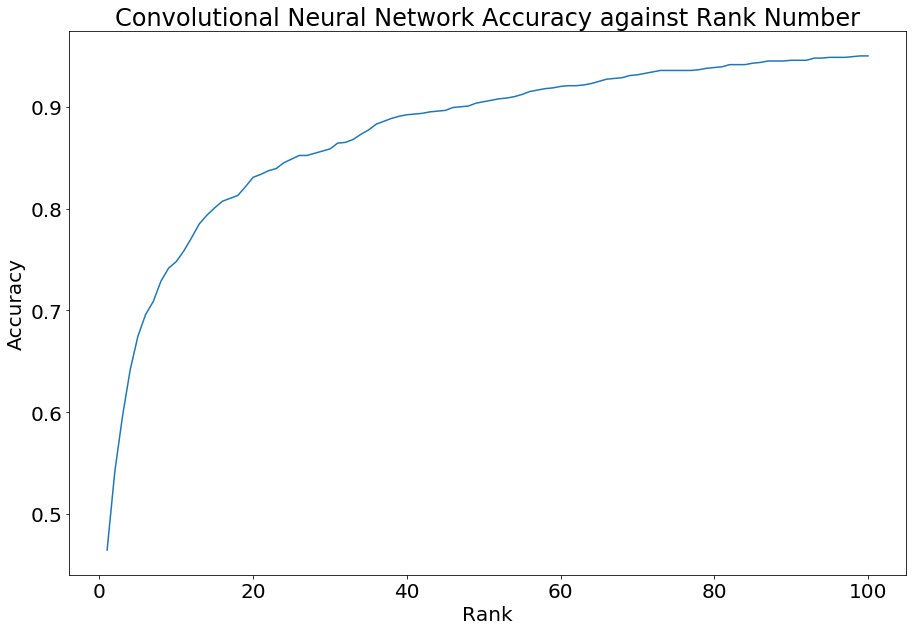

In [39]:
#model.save('PR_cnn_20181210.h5')

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (15,10)
plt.rcParams.update({'font.size': 20})
plt.plot(ranks, rank_scores)
plt.title('Convolutional Neural Network Accuracy against Rank Number')
plt.ylabel('Accuracy')
plt.xlabel('Rank')
plt.show()


In [43]:
# np.save('Predictions', predictions)
# np.save('Ranks', rank_scores)
# model.save('PR_cnn_20181211.h5')